In [50]:
# heavily based on:
# https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html

In [49]:
import networkx as nx

import torch
import torch.nn.functional as F

import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx, scatter
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid

print(torch.__version__)
print(torch_geometric.__version__)

2.3.0+cu118
2.5.3


In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Basics

In [3]:
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)


In [4]:
data = Data(x=x, edge_index=edge_index)


In [7]:
print(data)

Data(x=[3, 1], edge_index=[2, 4])


In [8]:
edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

In [77]:
print(type(edge_index))
print(edge_index.shape)
print(edge_index.t())

<class 'torch.Tensor'>
torch.Size([4, 2])
tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])


In [9]:
data = Data(x=x, edge_index=edge_index.t().contiguous())
# this does the following:
# 1. We create data based on edge_index and x
# 2. We transpose edge_index (torch.t() is for T, so transposing)
# 3. We make sure that the tensor is contiguous, 
#    which means that the memory is stored in a single block

In [10]:
print(data)

Data(x=[3, 1], edge_index=[2, 4])


In [11]:
data.validate(raise_on_error=True)

True

In [12]:
for key, item in data:
    print(f'{key}: {item} found in data')

x: tensor([[-1.],
        [ 0.],
        [ 1.]]) found in data
edge_index: tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]]) found in data


In [13]:
print(data.num_nodes)
print(data.num_edges)
print(data.num_node_features)
print(data.num_edge_features)
print(data.contains_isolated_nodes())
print(data.contains_self_loops())
print(data.is_directed())

3
4
1
0
False
False
False


c:\Users\Maciek\__repos\ml_concepts\venv\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
c:\Users\Maciek\__repos\ml_concepts\venv\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


## TUDataset

In [39]:
tud_dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')

### EDA

In [17]:
print(len(tud_dataset))

600


In [18]:
print(tud_dataset.num_classes)

6


In [19]:
print(tud_dataset.num_node_features)

3


In [20]:
print(tud_dataset[0])

Data(edge_index=[2, 168], x=[37, 3], y=[1])


In [21]:
print(tud_dataset[0].is_undirected())

True


In [25]:
G = to_networkx(tud_dataset[0], to_undirected=True)

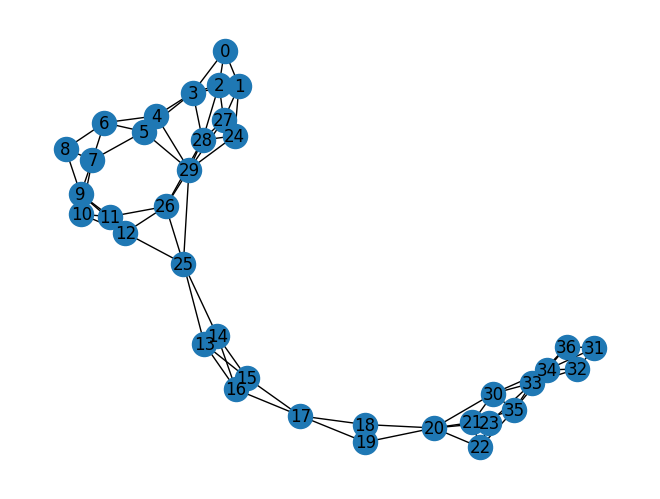

In [27]:
nx.draw(G, with_labels=True)

### Data Preprocessing

In [40]:
tud_loader = DataLoader(tud_dataset, batch_size=32, shuffle=True)

c:\Users\Maciek\__repos\ml_concepts\venv\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [42]:
for data in tud_loader:
    print(type(data))
    print(data)
    break

<class 'torch_geometric.data.batch.DataBatch'>
DataBatch(edge_index=[2, 3968], x=[1018, 3], y=[32], batch=[1018], ptr=[33])


In [48]:
x = scatter(data.x, data.batch, dim=0, reduce='mean')
print(x.size())
print(type(x))
print(x[:5])

torch.Size([32, 3])
<class 'torch.Tensor'>
tensor([[0.5714, 0.4286, 0.0000],
        [0.3429, 0.6571, 0.0000],
        [0.3636, 0.6364, 0.0000],
        [0.4348, 0.5652, 0.0000],
        [0.7222, 0.2778, 0.0000]])


## Planetoid

In [56]:
planetoid_dataset = Planetoid(root='/tmp/Cora', name='Cora')

### EDA

In [57]:
len(planetoid_dataset)

1

In [58]:
planetoid_dataset.num_classes

7

In [59]:
planetoid_dataset.num_node_features

1433

... so just a single, but very complicated and big graph.

In [33]:
G = to_networkx(planetoid_dataset[0], to_undirected=True)

In [35]:
# will take some time to run it and doesn't really make sense,
# as the img is not really readable
# nx.draw(G, with_labels=True)

## GCN

In [65]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(planetoid_dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, planetoid_dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [66]:
model = GCN().to(device)

In [67]:
data = planetoid_dataset[0].to(device)

In [68]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

### Train

In [69]:
num_epochs = 200

In [70]:
model.train()
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    print(f'Loss: {loss.item()}')
    loss.backward()
    optimizer.step()


Epoch 1/200
Loss: 1.9447503089904785
Epoch 2/200
Loss: 1.8437557220458984
Epoch 3/200
Loss: 1.7358181476593018
Epoch 4/200
Loss: 1.6231549978256226
Epoch 5/200
Loss: 1.5102763175964355
Epoch 6/200
Loss: 1.3794676065444946
Epoch 7/200
Loss: 1.24431574344635
Epoch 8/200
Loss: 1.1535457372665405
Epoch 9/200
Loss: 1.0689893960952759
Epoch 10/200
Loss: 0.9172961711883545
Epoch 11/200
Loss: 0.887378990650177
Epoch 12/200
Loss: 0.7525224685668945
Epoch 13/200
Loss: 0.6741389036178589
Epoch 14/200
Loss: 0.6183300614356995
Epoch 15/200
Loss: 0.5080072283744812
Epoch 16/200
Loss: 0.4586561918258667
Epoch 17/200
Loss: 0.4111659824848175
Epoch 18/200
Loss: 0.36079084873199463
Epoch 19/200
Loss: 0.313220351934433
Epoch 20/200
Loss: 0.2924312949180603
Epoch 21/200
Loss: 0.23288173973560333
Epoch 22/200
Loss: 0.23188629746437073
Epoch 23/200
Loss: 0.21336863934993744
Epoch 24/200
Loss: 0.1714058220386505
Epoch 25/200
Loss: 0.16974052786827087
Epoch 26/200
Loss: 0.1246093213558197
Epoch 27/200
Loss: 0

### Test

In [71]:
def get_accuracy(model: torch.nn.Module, data: Data) -> float:
    model.eval()
    pred = model(data).argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    print(f'Accuracy: {acc:.4f}')
    return acc

In [73]:
acc = get_accuracy(model, data)

Accuracy: 0.8040


In [74]:
print(acc)

0.804
